In [1]:
import pandas as pd
import numpy as np
import os, pickle, datetime
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from great_tables import GT, md, html
import statsmodels.api as sm
warnings.filterwarnings('ignore')

In [2]:
# Load and combine the files
world_dev = pd.read_excel('Data_Extract_From_World_Development_Indicators.xlsx')
poverty = pd.read_excel('Data_Extract_From_Poverty_and_Equity.xlsx')

df = pd.concat([world_dev, poverty], axis=0, ignore_index=True)

In [3]:
# Cleaning the data
df = df[df['Series Name'].notna()]
df['2016 [YR2016]'] = pd.to_numeric(df['2016 [YR2016]'], errors='coerce')
df['2015 [YR2015]'] = pd.to_numeric(df['2015 [YR2015]'], errors='coerce')
df['value'] = np.where(df['2016 [YR2016]'].isna(), df['2015 [YR2015]'], df['2016 [YR2016]'])

df.drop(columns=['2016 [YR2016]', '2015 [YR2015]', 'Series Code'], inplace=True)

# Now pivot the table
df = df.pivot_table(index=['Country Name', 'Country Code'], 
                columns='Series Name', 
                values='value', 
                aggfunc='first').reset_index()

codes_to_drop = [
    'ARB','CSS','CEB','EAR','EAS','TEA','EAP','ECS','TEC','ECA','EUU','FCS','HPC','HIC','IBD','IBT','IDB','DFS','IDX','IDA','LTE','LCN','LAC','TLA','LDC','LMY','LIC','LMC','MEA','TMN','MNA','MIC','NAC','OED','OSS','PSS','PST','PRE','SST','SAS','TSA','SSF','TSS','SSA','UMC','WLD'
    ]

df = df[~df['Country Code'].isin(codes_to_drop)]
df['Top-Bottom Quintile Ratio'] = df['Income share held by highest 20%'] / df['Income share held by lowest 20%']

In [4]:
cols_of_interest = [
    'Poverty gap at $1.90 a day (2011 PPP) (%)',
    'Poverty headcount ratio at $1.90 a day (2011 PPP) (% of population)',
    'GDP per capita, PPP (constant 2017 international $)',
    'Gini index (World Bank estimate)',
    'Top-Bottom Quintile Ratio'
    ]

p25 = lambda x: np.nanpercentile(x, 25)

to_agg = {}
for col in cols_of_interest:
    to_agg[col] = ['mean', 'median', 'min', 'max', 'std', ('25%', p25)]

# Aggregate the data
df['i']=1
agg_df = df.groupby(['i']).agg(to_agg).stack().T
# Get rid of the multi-index
agg_df.columns = agg_df.columns.map(lambda x: x[1] if isinstance(x, tuple) else x)
agg_df['Coef. Var.'] = agg_df['std'] / agg_df['mean']

In [5]:
# What is the interquartile range for inequality? What is the variance in inequality?
data = df[['Gini index (World Bank estimate)', 'Top-Bottom Quintile Ratio']].describe().loc[['25%', '75%', 'std']].T.rename(columns={'Gini index (World Bank estimate)': 'Gini', 'Top-Bottom Quintile Ratio': 'Top-Bottom Quintile Ratio'})
data['IQR'] = data['75%'] - data['25%']
data['Variance'] = data['std'] ** 2
data = data[['IQR', 'Variance']]
data

,IQR,Variance
Series Name,,
Gini index (World Bank estimate),10.50000,62.786471
Top-Bottom Quintile Ratio,3.65368,16.448368


In [6]:
agg_df = agg_df.rename(columns={
    'mean': 'Mean',
    'std': 'Std. Dev.',
    'min': 'Min',
    'max': 'Max',
    'median': 'Median',
    '25%': '25th Percentile'
})

# reindex so that 'GDP per capita, PPP (constant 2017 international $)' is at the bottom
agg_df = agg_df.reindex([
    'Poverty gap at $1.90 a day (2011 PPP) (%)',
    'Poverty headcount ratio at $1.90 a day (2011 PPP) (% of population)',
    'Gini index (World Bank estimate)',
    'Top-Bottom Quintile Ratio',
    'GDP per capita, PPP (constant 2017 international $)'
])

agg_df['Variable'] = agg_df.index
agg_df.reset_index(drop=True, inplace=True)

agg_df = agg_df[['Variable', 'Min', '25th Percentile', 'Median', 'Mean', 'Max', 'Std. Dev.', 'Coef. Var.']]

In [7]:
# turn into a GT table
gt_tbl = GT(agg_df)
gt_tbl = gt_tbl.fmt_number(columns=['Min', '25th Percentile', 'Median', 'Mean', 'Max', 'Std. Dev.', 'Coef. Var.'], decimals=1)

# Add a title, subtitle, and source note
gt_tbl = gt_tbl.tab_header(
    title="Summary Statistics of Poverty, Income, and Inequality",
    subtitle="All Countries, 2015/2016"
)

gt_tbl = gt_tbl.tab_source_note("Note: Uses data from 2016. If 2016 is unavailable, uses 2015 data.")

gt_tbl.write_raw_html('./output/summary_stats_table.html')

In [8]:
# Create a dummy variable to divide countries into three different income groups
df.sort_values(by='GDP per capita, PPP (constant 2017 international $)', inplace=True)

# Count the non-missing values.
count = df['GDP per capita, PPP (constant 2017 international $)'].count()

# create a categorical variable that splits the data into three equal groups
df['Income Group'] = pd.qcut(df['GDP per capita, PPP (constant 2017 international $)'], q=3, labels=['Low', 'Middle', 'High'])

In [9]:
# What proportion of the sample is rich/poor?
print(df[df['Income Group'] == 'High'].shape[0] / count, df[df['Income Group'] == 'Low'].shape[0] / count)

# proportion weighted by 'Population, total'
pops = df.groupby('Income Group')['Population, total'].sum()
pops / pops.sum()

0.33505154639175255 0.33505154639175255


Income Group
Low       0.409975
Middle    0.401948
High      0.188078
Name: Population, total, dtype: float64

In [10]:
# cross tabulation of inequality and poverty by income group
inequality_poverty = df.groupby('Income Group')[[
    'Poverty headcount ratio at $1.90 a day (2011 PPP) (% of population)',
    'Gini index (World Bank estimate)',
    'Top-Bottom Quintile Ratio'
]].mean()

inequality_poverty.rename(columns={
    'Poverty headcount ratio at $1.90 a day (2011 PPP) (% of population)': 'Poverty headcount %',
    'Gini index (World Bank estimate)': 'Gini index'
}, inplace=True)

# Create a GT table for the inequality and poverty cross tabulation
inequality_poverty_gt = GT(inequality_poverty.reset_index())
inequality_poverty_gt = inequality_poverty_gt.fmt_number(columns=['Poverty headcount %', 'Gini index', 'Top-Bottom Quintile Ratio'], decimals=1)
inequality_poverty_gt = inequality_poverty_gt.tab_header(
    title="Average Poverty and Inequality by Income Group",
    subtitle="All Countries, 2015/2016"
)
inequality_poverty_gt.write_raw_html('./output/inequality_poverty_table.html')

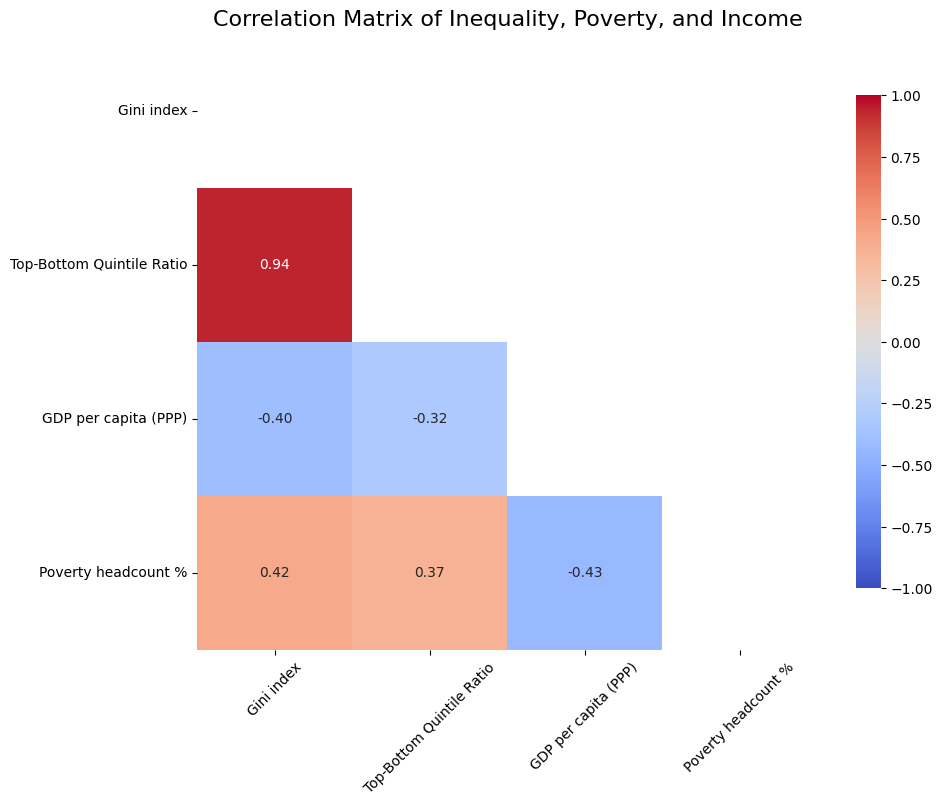

In [11]:
# What is the correlation between inequality, poverty, and income?
correlation_df = df[[
    'Gini index (World Bank estimate)', 
    'Top-Bottom Quintile Ratio',
    'GDP per capita, PPP (constant 2017 international $)', 
    'Poverty headcount ratio at $1.90 a day (2011 PPP) (% of population)', 
    ]].dropna()

correlation_df.rename(columns={
    'Poverty headcount ratio at $1.90 a day (2011 PPP) (% of population)': 'Poverty headcount %',
    'Gini index (World Bank estimate)': 'Gini index',
    'GDP per capita, PPP (constant 2017 international $)': 'GDP per capita (PPP)'
}, inplace=True)

correlation_matrix = correlation_df.corr()
correlation_matrix = correlation_matrix.round(2)

# Create a heatmap of the correlation matrix
plt.figure(figsize=(10, 8))
# Create a mask for the upper triangle
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(
    correlation_matrix,
    annot=True,
    cmap='coolwarm',
    fmt='.2f',
    square=False,
    cbar_kws={"shrink": .8},
    vmin=-1, vmax=1,
    mask=mask
)
plt.title('Correlation Matrix of Inequality, Poverty, and Income', fontsize=16)
plt.xlabel("")  # Remove x-axis title
plt.ylabel("")  # Remove y-axis title
plt.xticks(rotation=45)  # Rotate x labels by 45 degrees
plt.savefig('./output/correlation_matrix.png', bbox_inches='tight')

In [12]:
# Provide the five-number summary for inequality, poverty, and income, for the middle income countries only
middle_income_df = df[df['Income Group'] == 'Middle']

cols_of_interest = [
    'Poverty gap at $1.90 a day (2011 PPP) (%)',
    'Poverty headcount ratio at $1.90 a day (2011 PPP) (% of population)',
    'GDP per capita, PPP (constant 2017 international $)',
    'Gini index (World Bank estimate)',
    'Top-Bottom Quintile Ratio'
    ]

p25 = lambda x: np.nanpercentile(x, 25)

to_agg = {}
for col in cols_of_interest:
    to_agg[col] = ['mean', 'median', 'min', 'max', 'std', ('25%', p25)]

# Aggregate the data
df['i']=1
agg_df = middle_income_df.groupby(['i']).agg(to_agg).stack().T
# Get rid of the multi-index
agg_df.columns = agg_df.columns.map(lambda x: x[1] if isinstance(x, tuple) else x)
agg_df['Coef. Var.'] = agg_df['std'] / agg_df['mean']

In [13]:
agg_df = agg_df.rename(columns={
    'mean': 'Mean',
    'std': 'Std. Dev.',
    'min': 'Min',
    'max': 'Max',
    'median': 'Median',
    '25%': '25th Percentile'
})

# reindex so that 'GDP per capita, PPP (constant 2017 international $)' is at the bottom
agg_df = agg_df.reindex([
    'Poverty gap at $1.90 a day (2011 PPP) (%)',
    'Poverty headcount ratio at $1.90 a day (2011 PPP) (% of population)',
    'Gini index (World Bank estimate)',
    'Top-Bottom Quintile Ratio',
    'GDP per capita, PPP (constant 2017 international $)'
])

agg_df['Variable'] = agg_df.index
agg_df.reset_index(drop=True, inplace=True)

agg_df = agg_df[['Variable', 'Min', '25th Percentile', 'Median', 'Mean', 'Max', 'Std. Dev.', 'Coef. Var.']]

In [14]:
# turn into a GT table
gt_tbl = GT(agg_df)
gt_tbl = gt_tbl.fmt_number(columns=['Min', '25th Percentile', 'Median', 'Mean', 'Max', 'Std. Dev.', 'Coef. Var.'], decimals=1)

# Add a title, subtitle, and source note
gt_tbl = gt_tbl.tab_header(
    title="Summary Statistics of Poverty, Income, and Inequality",
    subtitle="Middle Third of Countries (by GDP per Capita), 2015/2016"
)

gt_tbl = gt_tbl.tab_source_note("Note: Uses data from 2016. If 2016 is unavailable, uses 2015 data.")
gt_tbl.write_raw_html('./output/summary_stats_table_middle_income.html')

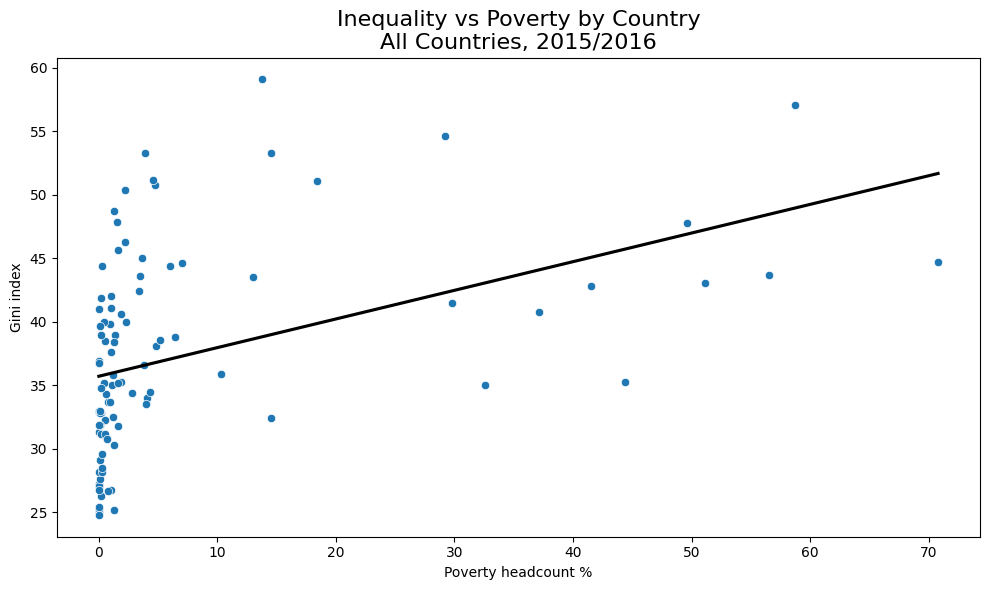

In [15]:
# Plot a scatterplot of poverty and inequality. Include a line of fit.
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df, 
    x='Poverty headcount ratio at $1.90 a day (2011 PPP) (% of population)', 
    y='Gini index (World Bank estimate)')

# add a line of fit
sns.regplot(
    data=df, 
    x='Poverty headcount ratio at $1.90 a day (2011 PPP) (% of population)', 
    y='Gini index (World Bank estimate)', 
    scatter=False, 
    color='black',
    ci=None)

plt.xlabel('Poverty headcount %')
plt.ylabel('Gini index')
plt.title('Inequality vs Poverty by Country\nAll Countries, 2015/2016', fontsize=16)
plt.grid(False)
plt.tight_layout()
plt.savefig("./output/Scatterplot Inequality vs Poverty.png")

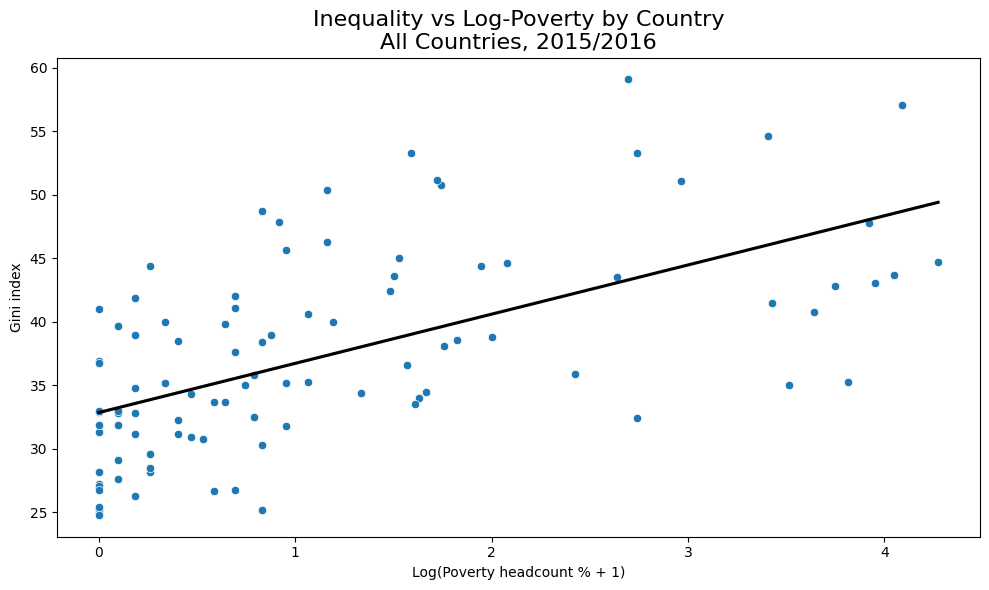

In [16]:
# Plot a scatterplot of poverty and inequality. Include a line of fit.
df['Log_Poverty'] = np.log1p(df['Poverty headcount ratio at $1.90 a day (2011 PPP) (% of population)'])

plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df, 
    x='Log_Poverty', 
    y='Gini index (World Bank estimate)')

# add a line of fit
sns.regplot(
    data=df, 
    x='Log_Poverty', 
    y='Gini index (World Bank estimate)', 
    scatter=False, 
    color='black',
    ci=None)

plt.xlabel('Log(Poverty headcount % + 1)')
plt.ylabel('Gini index')
plt.title('Inequality vs Log-Poverty by Country\nAll Countries, 2015/2016', fontsize=16)
plt.grid(False)
plt.tight_layout()
plt.savefig("./output/Scatterplot Inequality vs Log-Poverty.png")

In [17]:
def reg_util(df,x,y,out_path):
    df_sub = df[[x,y]].copy().dropna()
    X = sm.add_constant(df_sub[x])
    Y = df_sub[y]
    model = sm.OLS(Y, X).fit()
    with open(out_path, 'w') as f:
        f.write(model.summary().tables[1].as_latex_tabular())
    return model

In [18]:
# Run regresssions
df['GDP per capita, PPP ($Ks)'] = df['GDP per capita, PPP (constant 2017 international $)']/1000
df['Poverty headcount %'] = df['Poverty headcount ratio at $1.90 a day (2011 PPP) (% of population)']
df['Gini index'] = df['Gini index (World Bank estimate)']

# Income on poverty
reg_util(df, 
         'GDP per capita, PPP ($Ks)', 
         'Poverty headcount %',
         './output/reg_income_poverty.tex')

# Income on inequality
reg_util(df, 
         'GDP per capita, PPP ($Ks)', 
         'Gini index',
         './output/reg_income_inequality.tex')

# Inequality on poverty
reg_util(df, 
         'Gini index', 
         'Poverty headcount %',
         './output/reg_inequality_poverty.tex')

In [19]:
# Instead of using income, use the dummy variables for whether the country is rich vs poor in your regression of income on poverty
df_sub = df[['Income Group','Poverty headcount ratio at $1.90 a day (2011 PPP) (% of population)']].copy().dropna()
# convert the Income Group to dummy variables
df_sub = pd.get_dummies(df_sub, columns=['Income Group'], drop_first=False)*1

# Run regression of income on poverty using the dummy variables
X = sm.add_constant(df_sub[['Income Group_Low', 'Income Group_High']])
Y = df_sub['Poverty headcount ratio at $1.90 a day (2011 PPP) (% of population)']
model = sm.OLS(Y, X).fit()
with open('./output/reg_income_poverty_group.tex', 'w') as f:
    f.write(model.summary().tables[1].as_latex_tabular())

In [20]:
# Test the Kuznets hypothesis with a regression of inequality on income and income squared
df_sub = df[['GDP per capita, PPP (constant 2017 international $)', 'Gini index (World Bank estimate)']].copy().dropna()
df_sub['Income ($Ks)'] = df_sub['GDP per capita, PPP (constant 2017 international $)']/1000
df_sub['Income Squared ($Ks)'] = df_sub['Income ($Ks)'] ** 2

X = sm.add_constant(df_sub[['Income ($Ks)', 'Income Squared ($Ks)']])
Y = df_sub['Gini index (World Bank estimate)']
model = sm.OLS(Y, X).fit()
with open('./output/reg_kuznets.tex', 'w') as f:
    f.write(model.summary().tables[1].as_latex_tabular())

In [21]:
def reg_util2(df,x,y,title,out_path):
    df_sub = df[[x,y]].copy().dropna()
    X = sm.add_constant(df_sub[x])
    Y = df_sub[y]
    model = sm.OLS(Y, X).fit()
    df_sub['Residuals'] = model.resid

    #Histogram of residuals
    plt.figure(figsize=(10, 6))
    sns.histplot(df_sub['Residuals'], kde=True, bins=30)
    plt.title(title, fontsize=20)
    plt.xlabel('Residuals')
    plt.savefig(out_path)

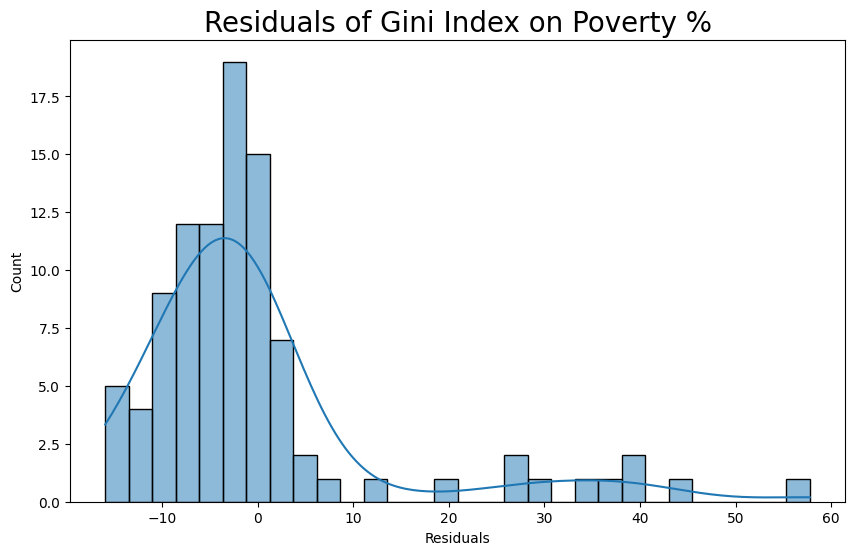

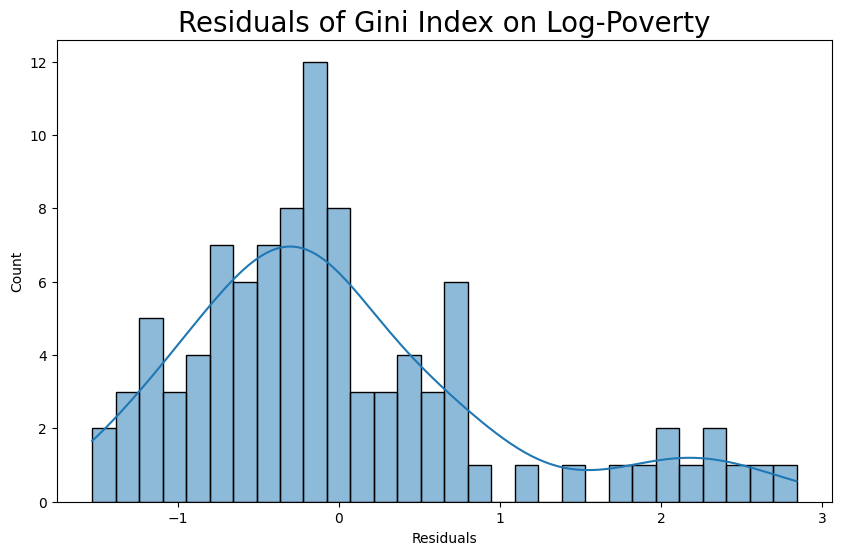

In [22]:
# Inequality on poverty
reg_util2(df, 
    'Gini index', 
    'Poverty headcount %',
    'Residuals of Gini Index on Poverty %',
    './output/hist_inequality_poverty.png')

# Inequality on log poverty
reg_util2(df, 
    'Gini index', 
    'Log_Poverty',
    'Residuals of Gini Index on Log-Poverty',
    './output/hist_inequality_log_poverty.png')

In [23]:
def reg_util3(df,x,y,title,out_path):
    df_sub = df[[x,y]].copy().dropna()
    X = sm.add_constant(df_sub[x])
    Y = df_sub[y]
    model = sm.OLS(Y, X).fit()
    df_sub['Residuals'] = model.resid

    #Histogram of residuals
    plt.figure(figsize=(10, 6))
    sns.scatterplot(df_sub, x=x, y='Residuals')
    # add a horizontal line at y=0
    plt.axhline(0, color='black', linestyle='--')
    plt.title(title, fontsize=20)
    plt.xlabel(x)
    plt.ylabel('Residuals')
    plt.savefig(out_path)

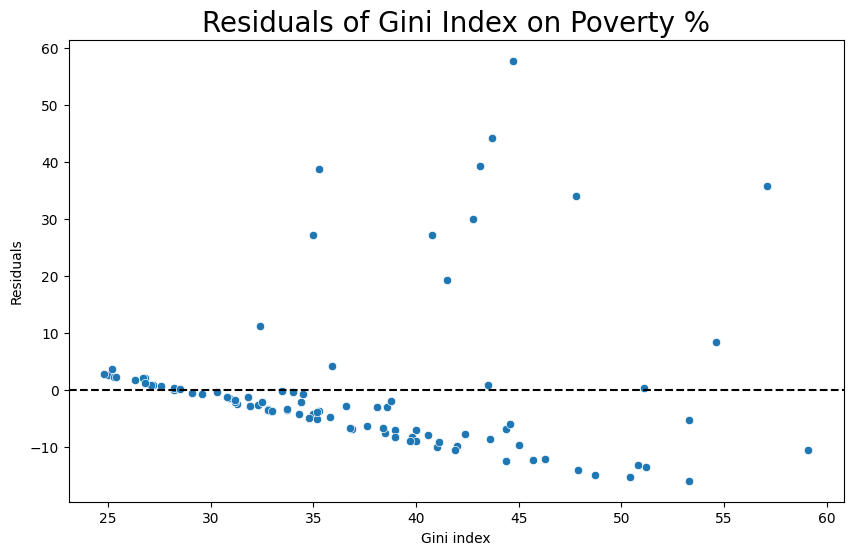

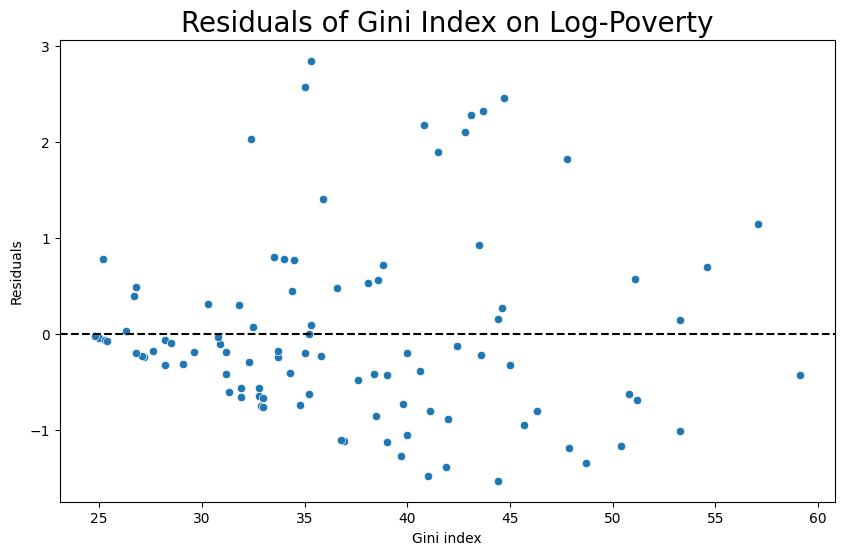

In [24]:
# Inequality on poverty
reg_util3(df, 
    'Gini index', 
    'Poverty headcount %',
    'Residuals of Gini Index on Poverty %',
    './output/scatter_inequality_poverty.png')

# Inequality on log poverty
reg_util3(df, 
    'Gini index', 
    'Log_Poverty',
    'Residuals of Gini Index on Log-Poverty',
    './output/scatter_inequality_log_poverty.png')

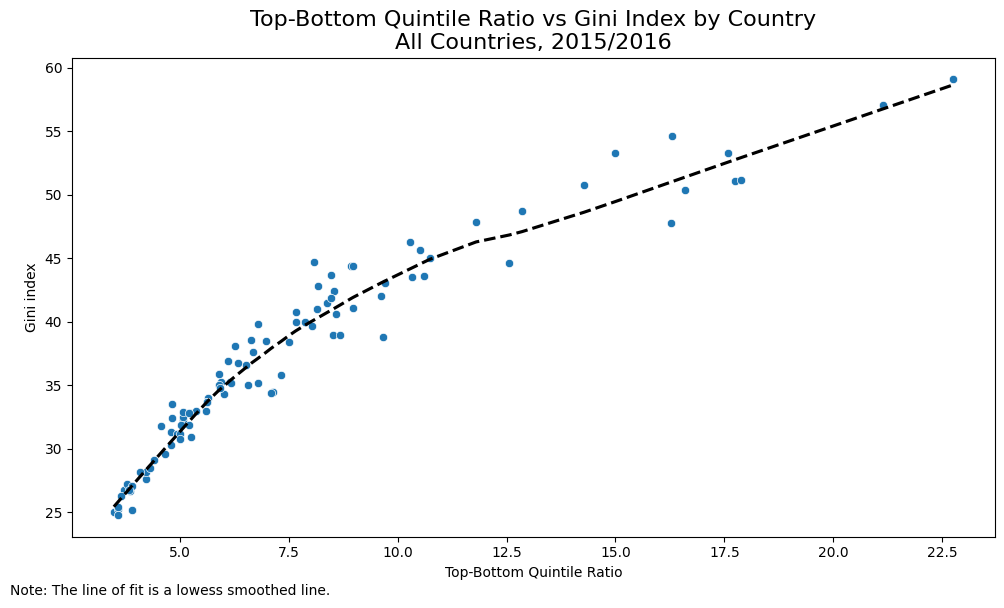

In [25]:
# Scatterplot of Gini vs ttop-bottom quintile ratio
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df, 
    x='Top-Bottom Quintile Ratio', 
    y='Gini index (World Bank estimate)')
# add a line of fit
sns.regplot(
    data=df, 
    x='Top-Bottom Quintile Ratio', 
    y='Gini index (World Bank estimate)', 
    scatter=False, 
    color='black',
    ci=None,
    lowess=True,
    line_kws={"linestyle": "--"})
plt.xlabel('Top-Bottom Quintile Ratio')
plt.ylabel('Gini index')
plt.title('Top-Bottom Quintile Ratio vs Gini Index by Country\nAll Countries, 2015/2016', fontsize=16)
plt.grid(False)
plt.tight_layout()
# add a note at the bottom
plt.figtext(0, 0, 'Note: The line of fit is a lowess smoothed line.', ha='left', fontsize=10)
plt.savefig("./output/Scatterplot Top-Bottom Quintile Ratio vs Gini Index.png")